In [ ]:
!sudo apt install tesseract-ocr -y
!pip install pytesseract opencv-python pandas numpy


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
tesseract-ocr is already the newest version (4.1.1-2.1build1).
0 upgraded, 0 newly installed, 0 to remove and 41 not upgraded.


In [ ]:
import cv2, numpy as np, pytesseract, re, json
from difflib import get_close_matches
from google.colab import files

# ---- standard parameter dictionary ----
STANDARD_PARAMS = {
    "hemoglobin":["hb","haemoglobin","hemoglobin","hb(g/dl)"],
    "rbc":["rbc","red blood cells"],
    "wbc":["wbc","white blood cells","tlc"],
    "platelets":["platelets","plts","plt"],
    "mcv":["mcv"], "mch":["mch"], "mchc":["mchc"],
    "hct":["hct","hematocrit","pcv"],
    "glucose":["glucose","blood sugar","fbs","rbs"],
    "tsh":["tsh"],
    "alt":["alt","sgpt"], "ast":["ast","sgot"]
}
NAME_POOL = []
for k,v in STANDARD_PARAMS.items():
    NAME_POOL += [k] + v


def preprocess(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    gray = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
    th = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                               cv2.THRESH_BINARY,15,9)
    if np.mean(th) < 127:
        th = cv2.bitwise_not(th)
    return th

def ocr_image(th_img):
    cfg = '--oem 3 --psm 6 -c preserve_interword_spaces=1'
    return pytesseract.image_to_string(th_img, config=cfg, lang='eng')

def extract_pairs(raw_text):
    lines = [l.strip() for l in raw_text.splitlines() if l.strip()]
    pairs = []
    value_rx = re.compile(r'(-?\d+(\.\d+)?)(\s*[-–]\s*-?\d+(\.\d+)?)?')
    for line in lines:
        parts = re.split(r'\s{2,}|\t|\s-\s|:|,\s', line)
        for part in parts:
            m = value_rx.search(part)
            if m:
                val = m.group(0).strip()
                label = part.replace(val, '').strip(' :.-')
                if not label:
                    toks = line.split()
                    for i,tok in enumerate(toks):
                        if value_rx.search(tok):
                            label = ' '.join(toks[:i]).strip()
                            break
                pairs.append((label, val, line))
                break
    return pairs

def map_label(label):
    lab = re.sub(r'[^a-z0-9\%\s\(\)/\-\.]', ' ', label.lower()).strip()
    if not lab: return None
    for std, variants in STANDARD_PARAMS.items():
        if lab == std or lab in variants: return std
    matches = get_close_matches(lab, NAME_POOL, n=1, cutoff=0.6)
    if matches:
        m = matches[0]
        for std, variants in STANDARD_PARAMS.items():
            if m == std or m in variants: return std
    for std in STANDARD_PARAMS:
        if std in lab: return std
    return None

def normalize_value(vstr):
    vstr = vstr.replace(',', '.')
    m = re.search(r'-?\d+(\.\d+)?(\s*[-–]\s*-?\d+(\.\d+)?)?', vstr)
    return m.group(0).strip() if m else vstr.strip()

def parse_image(path, verbose=False):
    img = cv2.imread(path)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    pre = preprocess(img)
    txt = ocr_image(pre)
    if verbose:
        print("===== OCR RAW TEXT =====\n", txt)
    pairs = extract_pairs(txt)
    parsed, raw = {}, []
    for label, val, line in pairs:
        std = map_label(label)
        norm = normalize_value(val)
        raw.append({"label":label,"raw":val,"line":line,"mapped":std,"normalized":norm})
        if std:
            parsed[std] = norm
    return {"parsed": parsed, "raw": raw, "ocr_text": txt}


✅ Synthetic report generated: sample_blood_report.jpg


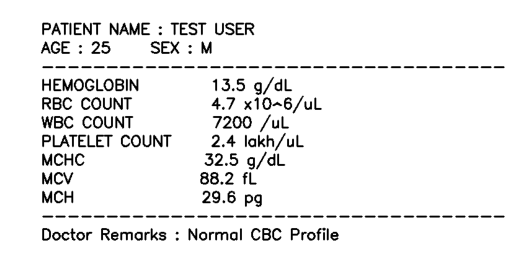

In [ ]:
# 🔹 Create a synthetic sample blood report image to test OCR

import cv2
import numpy as np

# Create blank white image
img = np.ones((400,800,3), dtype=np.uint8) * 255

# Add sample text (simulate a printed lab report)
text_lines = [
    "PATIENT NAME : TEST USER",
    "AGE : 25     SEX : M",
    "-------------------------------------------",
    "HEMOGLOBIN         13.5 g/dL",
    "RBC COUNT          4.7 x10^6/uL",
    "WBC COUNT          7200 /uL",
    "PLATELET COUNT     2.4 lakh/uL",
    "MCHC               32.5 g/dL",
    "MCV                88.2 fL",
    "MCH                29.6 pg",
    "-------------------------------------------",
    "Doctor Remarks : Normal CBC Profile"
]

y = 40
for line in text_lines:
    cv2.putText(img, line, (50, y), cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,0), 2)
    y += 30

# Save image
cv2.imwrite("sample_blood_report.jpg", img)
print("✅ Synthetic report generated: sample_blood_report.jpg")

# Display the image
from matplotlib import pyplot as plt
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
plt.show()


In [ ]:
uploaded = files.upload()
img_path = list(uploaded.keys())[0]
print("Uploaded:", img_path)


Saving download.png to download (1).png
Uploaded: download (1).png


In [ ]:
result = parse_image(img_path, verbose=True)
print("\n===== STRUCTURED OUTPUT =====")
print(json.dumps(result["parsed"], indent=2))


===== OCR RAW TEXT =====
 PATIENT NAME : TEST USER

AGE: 25 SEX: M

HEMOGLOBIN        13.5 g/dL

RBC COUNT         4.7 x10-6/ul
WEC COUNT         7200 /ul.
PLATELET COUNT 2.4 lakh/ut.
MCHC             32.5 g/dL

Nev              88.2 fL

MCH              29.6 pg

Doctor Remarks : Normal CBC Profile


===== STRUCTURED OUTPUT =====
{
  "hemoglobin": "32.5"
}


In [ ]:
with open("ocr_output.json","w") as f:
    json.dump(result, f, indent=2)
files.download("ocr_output.json")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>